In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import patsy
import pystan
import arviz as az
import stan_utility
import glob,os

plt.style.use('seaborn-ticks')

order = ["Accuracy","Speed"]
df = dffull = pd.read_csv('../Raw_data/markers/MRK_SAT.csv')
df = df[df.exp==2]
df = df[(df.trialType == "SA") & (np.isfinite(df.pmt))].reset_index(drop=True)#Removing unmarked EMG trials

/home/gabriel/anaconda3/envs/pystan/lib/python3.7/site-packages/xarray/core/merge.py:18: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)
/home/gabriel/anaconda3/envs/pystan/lib/python3.7/site-packages/xarray/core/dataarray.py:1829: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  'DataArray', pd.Series, pd.DataFrame, pd.Panel]:


# PMT-MT Correlation coefficient on fast-guesses

## Applying EWMA on PMT

In [2]:
from EWMA import ewmaseg

trimmed_df = df.reset_index(drop=True)

In [3]:
fastguess_corr = [] #Storing trials identified as fast-guesses
for sub, subdat in trimmed_df.groupby(['participant','condition']):
    initial = len(subdat)
    cutoff = ewmaseg(subdat.response.values, subdat.pmt.values, alpha=.02, limit=.6, plotit=False)['rtbound']
    #Turn plotit True for rejection plot
    fastguess_corr.append([np.corrcoef(subdat[subdat.pmt < cutoff].mt, subdat[subdat.pmt < cutoff].pmt)[0, 1], subdat[subdat.pmt < cutoff].pmt.mean(), sub[0], sub[1]])
    trimmed_df.drop(subdat[subdat.pmt < cutoff].index, inplace =True, axis=0)
    print("Cutoff = %i ms for participant %s in condition %s. %i trials removed" 
          %(np.round(cutoff), sub[0], sub[1], len(subdat[subdat.pmt < cutoff].index)))
    plt.show()
fastguess_corr = pd.DataFrame(fastguess_corr, columns=["correl", "pmt", "participant", "SAT"])

Cutoff = 221 ms for participant S10_2 in condition Accuracy. 23 trials removed
Cutoff = 200 ms for participant S10_2 in condition Speed. 23 trials removed
Cutoff = 213 ms for participant S11_2 in condition Accuracy. 22 trials removed
Cutoff = 204 ms for participant S11_2 in condition Speed. 247 trials removed
Cutoff = 313 ms for participant S12_2 in condition Accuracy. 21 trials removed
Cutoff = 260 ms for participant S12_2 in condition Speed. 57 trials removed
Cutoff = 227 ms for participant S13_2 in condition Accuracy. 29 trials removed
Cutoff = 155 ms for participant S13_2 in condition Speed. 130 trials removed
Cutoff = 223 ms for participant S14_2 in condition Accuracy. 59 trials removed
Cutoff = 138 ms for participant S14_2 in condition Speed. 111 trials removed
Cutoff = 249 ms for participant S15_2 in condition Accuracy. 30 trials removed
Cutoff = 262 ms for participant S15_2 in condition Speed. 398 trials removed
Cutoff = 344 ms for participant S16_2 in condition Accuracy. 12 tr

### Comparing fast-guess removal between PMT and RT distributions

(0.9431987172458611, 6.708404361149943e-16)


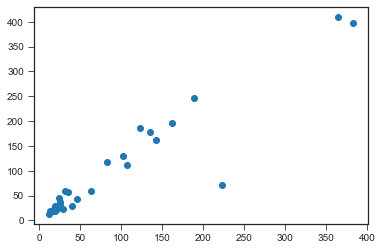

In [4]:
trim = []

for sub, subdat in df.groupby(['participant','condition']):
    rt_cutoff = ewmaseg(subdat.response.values, subdat.rt.values, alpha=.02, limit=.6, plotit=False)['rtbound']
    rt_trim = len(subdat[subdat.rt < rt_cutoff].index)
    pmt_cutoff = ewmaseg(subdat.response.values, subdat.pmt.values, alpha=.02, limit=.6, plotit=False)['rtbound']
    pmt_trim = len(subdat[subdat.pmt < pmt_cutoff].index)
    trim.append([rt_trim, pmt_trim])
trim = [[x[0] for x in trim],[x[1] for x in trim]]

print(stats.pearsonr(trim[0], trim[1]))
plt.plot(trim[0], trim[1],'o')
plt.show()

## LMM on fast-guess correlations

In [5]:
LME = stan_utility.compile_model('MixedModels/LME.stan', path="MixedModels/", model_name="LME")

Using cached StanModel


In [6]:
fastguess_corr['participant'] = [int(x.split('S')[-1].split('_')[0]) for x in fastguess_corr.participant]
fixeff_form = "1+SAT"#Fixed effects formula
raneff_form = "1"#Random effects formula
fixeff = np.asarray(patsy.dmatrix(fixeff_form, fastguess_corr)) #FE design matrix
raneff = np.asarray(patsy.dmatrix(raneff_form, fastguess_corr))
prior_intercept = np.asarray([0,.3])
priors_mu =  np.asarray([0])#Priors on mu for FE
priors_sigma = np.asarray([.3])# priors on sigma for FE
priors_raneff = np.asarray([0,.3])#Priors on RE
prior_sd = np.asarray([0,.3])

r_data = dict(
    N = len(fastguess_corr),
    P = fixeff.shape[-1], #number of pop level effects 
    J = len(fastguess_corr.participant.unique()),
    n_u = raneff.shape[-1],
    subj = fastguess_corr.participant,
    X = fixeff,
    Z_u = raneff,
    y = fastguess_corr.correl.values,
    p_intercept = prior_intercept, p_fmu = priors_mu, p_fsigma = priors_sigma, p_r = priors_raneff, p_sd=prior_sd,
    logT = 0
)

if os.path.exists("MixedModels/r_fit_FG_exp2.nc"):
    r_fit_FG = az.from_netcdf("MixedModels/r_fit_FG_exp2.nc")

else:
    r_fit_FG = LME.sampling(data=r_data, iter=2000, chains=6, n_jobs=6, 
                              warmup = 1000,  control=dict(adapt_delta=0.95))
    r_fit_FG = az.from_pystan(posterior=r_fit_FG, posterior_predictive='y_hat', observed_data="y", log_likelihood='log_lik',
                                       coords={'b': fixeff_form.split('+')[1:]}, dims={'beta': ['b']})
    r_fit_FG.to_netcdf("MixedModels/r_fit_FG_exp2.nc")


Plotting coefficients

/home/gabriel/anaconda3/envs/pystan/lib/python3.7/site-packages/arviz/plots/forestplot.py:207: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  ticks.tick1On = False
/home/gabriel/anaconda3/envs/pystan/lib/python3.7/site-packages/arviz/plots/forestplot.py:208: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  ticks.tick2On = False


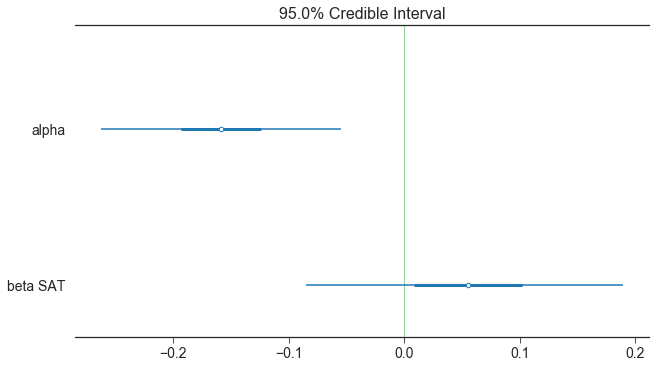

In [7]:
g = az.plot_forest(r_fit_FG,var_names=["alpha","beta"], credible_interval=0.95, combined=True, 
                   rope=[0, 0], figsize=(9,5))
plt.show()

Posterior summary values

In [8]:
az.summary(r_fit_FG, credible_interval=.95)[:3]

/home/gabriel/anaconda3/envs/pystan/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/gabriel/anaconda3/envs/pystan/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/gabriel/anaconda3/envs/pystan/lib/python3.7/site-packages/arviz/stats/diagnostics.py:631: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/gabriel/anaconda3/envs/pystan/lib/python3.7/site-packages/arviz/stats/diagnostics.py:631: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hpd_2.5%,hpd_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,-0.158,0.052,-0.262,-0.055,0.001,0.001,4463.0,4343.0,4474.0,3874.0,1.0
sigma,0.204,0.028,0.155,0.262,0.000,0.000,5390.0,5170.0,5496.0,4112.0,1.0
beta[0],0.055,0.070,-0.085,0.190,0.001,0.001,4885.0,4237.0,4887.0,4441.0,1.0


## Computing correlation by quantiles on trimmed data

In [9]:
r, part, SAT, quantile,names = [],[],[],[],[]

for xx, subj_dat in trimmed_df.groupby(['participant', 'condition']):
    subj_dat = subj_dat.copy()
    subj_dat["quant"] = pd.qcut(subj_dat.pmt, 5)#creating quantile columns
    #renaming :
    name_quanti = [str(a) for a in subj_dat.groupby("quant").pmt.mean().index]
    mpmt = subj_dat.groupby("quant").pmt.mean().values
    subj_dat["quant"] = [str(a) for a in subj_dat["quant"]]
    subj_dat["quant"] = subj_dat["quant"].replace(name_quanti, mpmt)
    subj_dat["names"] = pd.qcut(subj_dat.pmt, 5, labels=False)
    #computing spearman correlation by quantile :
    for quant, quant_dat in subj_dat.groupby('quant'):
        r.append(stats.spearmanr(quant_dat.mt, quant_dat.pmt)[0])
        part.append(xx[0])
        SAT.append(xx[1])
        quantile.append(quant)
        names.append(quant_dat.names.unique()[0])
dfcorr = pd.concat([pd.Series(r), pd.Series(part),pd.Series(SAT),pd.Series(quantile),pd.Series(names)], axis=1)
dfcorr.columns = ['correl','participant','SAT','quant','names']

## Constructing null confidence intervals around correlation values on two random variables

In [10]:
from random import sample
permuted_r = []
lengths = trimmed_df.groupby(['participant','condition']).count().trial #taking real number of trial participant X SAT

for i in np.arange(10000):
    r = []
    for j in lengths:
        r.append(stats.spearmanr(sample(set(zip(np.random.normal(0,1, j),np.random.normal(0,1, j))), int(j/5)))[0])
    permuted_r.append(np.mean(r))
permuted_r = np.asarray(permuted_r)

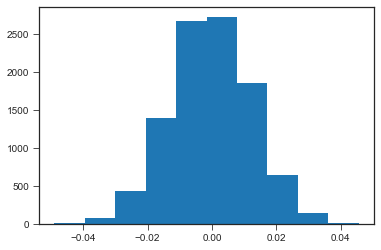

In [11]:
g=plt.hist(permuted_r)

# Plotting

Adding correlation between PMT and MT for identified fast-guesses

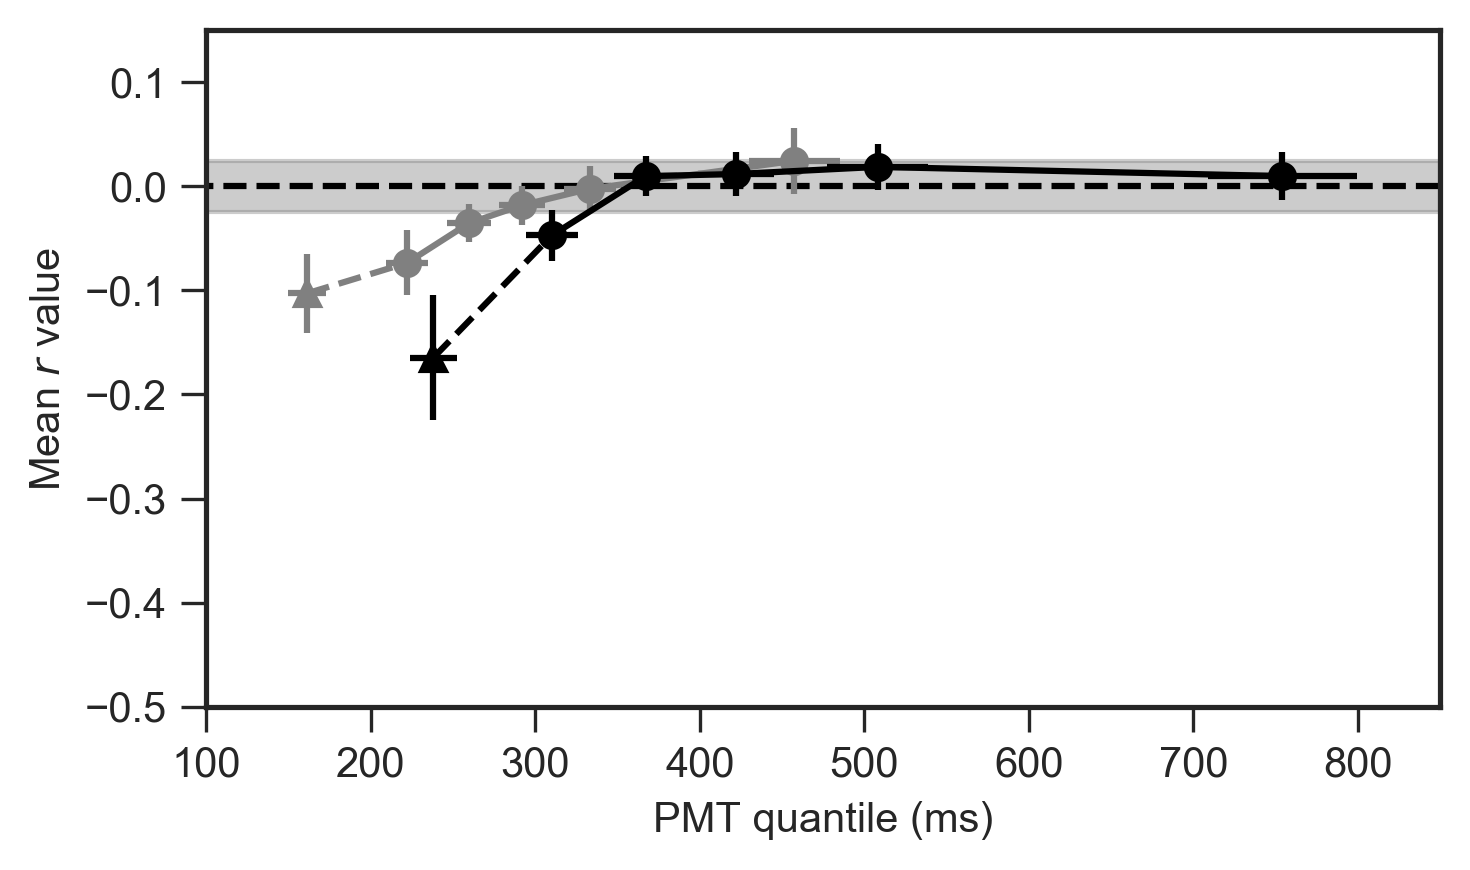

In [13]:
from matplotlib.lines import Line2D
from matplotlib.patches import Polygon

permuted_r = np.asarray(permuted_r)
fig = plt.figure(dpi=300, figsize=(5,3))
plt.hlines(permuted_r.mean() , 50,900, linestyle='--')
ci95pos,ci95neg = permuted_r.mean() + permuted_r.std() * 1.96, permuted_r.mean() - permuted_r.std() * 1.96
plt.fill([50, 850, 850, 50], [ci95neg, ci95neg, ci95pos, ci95pos], color="gray", alpha=0.4)
plt.ylim(-.5,.15)
subset = dfcorr[dfcorr.SAT == "Speed"]
sd_pmt = subset.groupby('names').quant.std()
sd_corr = subset.groupby('names').correl.std()
plt.errorbar(subset.groupby('names').quant.mean(), subset.groupby('names').correl.mean(),
             xerr=(sd_pmt/np.sqrt(16)), yerr= (sd_corr/np.sqrt(16)),
             fmt="-o", color="gray", label="Quantiles in Speed")
subset = fastguess_corr[fastguess_corr.SAT == "Speed"]
sd_pmt = subset.pmt.std()
sd_corr = subset.correl.std()
plt.errorbar(subset.pmt.mean(), subset.correl.mean(),
             xerr=(sd_pmt/np.sqrt(16)), yerr= (sd_corr/np.sqrt(16)),
             fmt="^", color="gray",  label="Fast-guesses in Speed")
plt.plot([subset.pmt.mean(), dfcorr[(dfcorr.SAT == "Speed") & (dfcorr.names == 0)].quant.mean()], 
          [subset.correl.mean(), dfcorr[(dfcorr.SAT == "Speed") & (dfcorr.names == 0)].correl.mean()], '--', color="gray")
subset = dfcorr[dfcorr.SAT == "Accuracy"]
sd_pmt = subset.groupby('names').quant.std()
sd_corr = subset.groupby('names').correl.std()
plt.errorbar(subset.groupby('names').quant.mean(), subset.groupby('names').correl.mean(),
             xerr=(sd_pmt/np.sqrt(16)), yerr= (sd_corr/np.sqrt(16)),
             fmt="-o", color="k", label="Quantiles in Accuracy")
subset = fastguess_corr[fastguess_corr.SAT == "Accuracy"]
sd_pmt = subset.pmt.std()
sd_corr = subset.correl.std()
plt.errorbar(subset.pmt.mean(), subset.correl.mean(),             
             xerr=(sd_pmt/np.sqrt(16)), yerr= (sd_corr/np.sqrt(16)),
             fmt="^", color="k",  label="Fast-guesses in Accuracy")
plt.plot([subset.pmt.mean(), dfcorr[(dfcorr.SAT == "Accuracy") & (dfcorr.names == 0)].quant.mean()], 
          [subset.correl.mean(), dfcorr[(dfcorr.SAT == "Accuracy") & (dfcorr.names == 0)].correl.mean()], '--', color="k")
plt.xlim(100, 850)



legend_elements = [Line2D([], [], marker="s", markersize=6, linewidth=0, color="k", label="Accuracy"),
                   Line2D([], [], marker="s", markersize=6, linewidth=0, color="gray", label="Speed"),
                   Line2D([0], [0], marker='o', color='darkgray', label='Quantile',
                          markerfacecolor='w', markersize=8),
                   Line2D([0], [0], marker='^', color='darkgray', label='Fast guesses',
                          markerfacecolor='w', markersize=8)]

plt.ylabel(r"Mean $r$ value")
plt.xlabel("PMT quantile (ms)")
plt.tight_layout()

plt.savefig('../Manuscript/plots/Quantcorr2.png')